# Assignment 2

During the exercises, you will compute the nonparametric bootstrap distribution of the Pearson’s
correlation coefficient between LSAT and GPA using B = 40000 bootstrap samples.

## Exercise 8.1: The Nonparametric Bootstrap

_Compute the nonparametric bootstrap distribution of the Pearson’s correlation coefficient between LSAT
and GPA using B = 40000 bootstrap samples._

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm

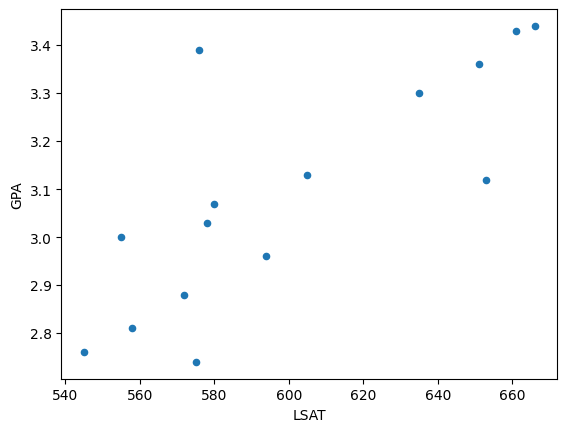

In [2]:
df = pd.read_csv("law.csv")
df.plot.scatter(x="LSAT", y="GPA")
plt.show()

In [3]:
np.corrcoef(df["LSAT"], df["GPA"])

array([[1.        , 0.77637449],
       [0.77637449, 1.        ]])

In [4]:
np.corrcoef(df.values.T)

array([[1.        , 0.77637449],
       [0.77637449, 1.        ]])

In [5]:
def bootstrap(data):
    return [random.choice(data) for _ in range(len(data))]

np.array(bootstrap(df.values)).shape, np.stack(bootstrap(df.values), axis=1).shape

((15, 2), (2, 15))

In [6]:
def bootstrap_df(df):
    return pd.DataFrame(bootstrap(df.values), columns=df.columns)

bootstrap_df(df)

,LSAT,GPA
0,545.0,2.76
1,635.0,3.30
2,575.0,2.74
3,545.0,2.76
4,605.0,3.13
5,572.0,2.88
6,666.0,3.44
7,605.0,3.13
8,545.0,2.76
9,666.0,3.44


In [7]:
np.corrcoef(bootstrap_df(df).values.T)

array([[1.        , 0.65261609],
       [0.65261609, 1.        ]])

In [8]:
distribution = [np.corrcoef(bootstrap_df(df).values.T)[0][1] for _ in range(40_000)]

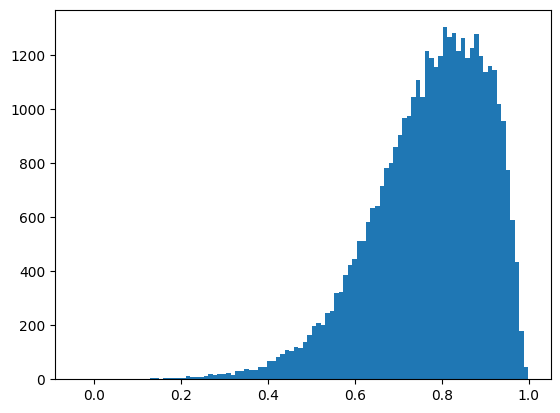

In [9]:
plt.hist(distribution, bins=100)
plt.show()

In this assignment, work on these additional tasks:

## 1. Complete enumeration bootstrap

_Recompute using the complete enumeration bootstrap._

From https://docs.python.org/3/library/itertools.html:

![](img/itertools.png)

In [10]:
from itertools import combinations_with_replacement

n = len(df)
enumeration = list(combinations_with_replacement(list(range(n)), n))
len(enumeration)

77558760

```python
data = df.values
corrcoefs = []
for e in tqdm(enumeration):
    c = np.corrcoef(data[list(e)].T)
    corrcoefs.append(c[0][1])
pd.DataFrame(corrcoefs).to_csv("complete_enumeration_corrcoefs.csv", index=False)
```

We run this externally in [`complete_enumeration.py`](complete_enumeration.py). The resulting CSV is of size 1.3 GB, so we do not include it in the repo.

In [11]:
import os

df_path = "complete_enumeration_corrcoefs.csv"
if os.path.exists(df_path):
    complete_enumeration_df = pd.read_csv(df_path)
    fig, ax = plt.subplots()
    complete_enumeration_df.hist(bins=100, alpha=0.5, color="red", ax=ax, label="complete enumeration", density=True)
    ax.hist(distribution, bins=100, alpha=0.5, color="blue", label="bootstrap B = 40 000", density=True)
    ax.legend(loc='upper left')
    plt.savefig("img/complete_enumeration_vs_bootstrap.png")
    plt.close()

![](img/complete_enumeration_vs_bootstrap.png)

## 2. Gray codes

_Use Gray codes for compositions to speedup computations._

In [12]:
from math import factorial

def graycode_composition(n):
    length = int(factorial(2*n-1)/(factorial(n-1)*factorial(2*n-1-(n-1))))
    compositions = np.zeros((length, n))

    # first combination
    curr = np.zeros(n)
    curr[0] = n
    compositions[0, :] = curr
    p = 0
    pos=1

    while (curr[n-1] != n): # we are done once n is in last
        if p == 0:
            if np.count_nonzero(curr) > 1:
                b = np.flatnonzero(curr)[1]
            else:
                b=0
            if b == 1:
                if curr[0] == 1:
                    p = 1
            elif (n - curr[0]) % 2 == 0:
                d, i, p = 0, 1, 1
            elif curr[b] % 2 == 1:
                d, i, p = 0, b, b
            else:
                i, d = 0, b
        else:
            if (n - curr[p]) % 2 == 1:
                d, i = p, p-1
                if curr[p] % 2 == 0:
                    i = 0
                p = i
            elif curr[p+1] % 2 == 0:
                i, d = p+1, p
                if curr[p] == 1:
                    p= p+1
            else:
                i, d = p, p+1
        curr[i] +=1
        curr[d] -= 1
        if curr[0] > 0:
            p=0
        compositions[pos] = curr
        pos += 1
    return compositions

graycode_composition(5) 


 

array([[5., 0., 0., 0., 0.],
       [4., 1., 0., 0., 0.],
       [3., 2., 0., 0., 0.],
       [2., 3., 0., 0., 0.],
       [1., 4., 0., 0., 0.],
       [0., 5., 0., 0., 0.],
       [0., 4., 1., 0., 0.],
       [1., 3., 1., 0., 0.],
       [2., 2., 1., 0., 0.],
       [3., 1., 1., 0., 0.],
       [4., 0., 1., 0., 0.],
       [3., 0., 2., 0., 0.],
       [2., 1., 2., 0., 0.],
       [1., 2., 2., 0., 0.],
       [0., 3., 2., 0., 0.],
       [0., 2., 3., 0., 0.],
       [1., 1., 3., 0., 0.],
       [2., 0., 3., 0., 0.],
       [1., 0., 4., 0., 0.],
       [0., 1., 4., 0., 0.],
       [0., 0., 5., 0., 0.],
       [0., 0., 4., 1., 0.],
       [1., 0., 3., 1., 0.],
       [0., 1., 3., 1., 0.],
       [0., 2., 2., 1., 0.],
       [1., 1., 2., 1., 0.],
       [2., 0., 2., 1., 0.],
       [3., 0., 1., 1., 0.],
       [2., 1., 1., 1., 0.],
       [1., 2., 1., 1., 0.],
       [0., 3., 1., 1., 0.],
       [0., 4., 0., 1., 0.],
       [1., 3., 0., 1., 0.],
       [2., 2., 0., 1., 0.],
       [3., 1.

In [13]:
from math import factorial

def n_w_composition(n):
    """N-W algorithm to run through the compositions
    """
    length = int(factorial(2*n-1)/(factorial(n-1)*factorial(2*n-1-(n-1))))
    compositions = np.zeros((length, n))

    # first combination
    curr = np.zeros(n)
    curr[0] = n
    compositions[0, :] = curr

    value_first_nonzero = n
    i = 1
    while (curr[n-1] != n): # we are done once n is in last
        if value_first_nonzero != 1:
            first_nonzero = 0
        else:
            first_nonzero += 1
        value_first_nonzero = curr[first_nonzero]
        curr[first_nonzero] = 0
        curr[0] = value_first_nonzero - 1
        curr[first_nonzero+1] = curr[first_nonzero+1] +1
        compositions[i, :] = curr
        i += 1
    return compositions

print(n_w_composition(3))

[[3. 0. 0.]
 [2. 1. 0.]
 [1. 2. 0.]
 [0. 3. 0.]
 [2. 0. 1.]
 [1. 1. 1.]
 [0. 2. 1.]
 [1. 0. 2.]
 [0. 1. 2.]
 [0. 0. 3.]]


In [14]:
df = pd.read_csv("law.csv")

df_n4 = df.iloc[0:4, :]

n = df_n4.shape[0]
print(df_n4.head())

graycodes_for_computation = graycode_composition(n)

   LSAT   GPA
0   576  3.39
1   635  3.30
2   558  2.81
3   578  3.03


In [15]:
graycodes_for_computation.shape

(35, 4)

The generation of the gray codes inside the Jupyter Notebook took around 2 to 3 minutes.

In [118]:
def complete_enumeration_with_graycodes(n=4):
    graycodes = graycode_composition(n)
    df = pd.read_csv("law.csv")

    data = df.iloc[0:n, :]
    data = data.values

    data = data.T
    
    correlations = data[0] * data[1]
    lsat_square = data[0]**2
    gpa_square = data[1]**2

    corrs = []

    for graycode in tqdm(graycodes, total=graycodes.shape[0]):
        # formula 
        # numerator n* sum (xi*yi) - sum(x)*sum(y)
        curr_x = np.sum(graycode*data[0])
        curr_y = np.sum(graycode*data[1])
        corr = n*np.sum(np.dot(graycode, correlations)) - curr_x*curr_y
        # denominator
        # sqrt(n* sum (x_square)-sum(x)**2) * sqrt(n*sum(y_square)-sum(y)**2)
        corr = corr/(np.sqrt(n* np.sum(np.dot(graycode, lsat_square))-curr_x**2)*np.sqrt(n * np.sum(np.dot(graycode, gpa_square))-curr_y**2))
        corrs.append(corr)
    return corrs

In [94]:
import itertools


def complete_enumeration_without_graycodes(n=4):
    graycodes = graycode_composition(n)
    df = pd.read_csv("law.csv")

    data = df.iloc[0:n, :]
    data = data.values

    corrs = []

    for graycode in tqdm(graycodes):
        indices = list(itertools.chain(*[[i]*int(g) for i, g in enumerate(graycode)]))
        corr = np.corrcoef(data[indices].T)[0][1]
        corrs.append(corr)

    return corrs


In [120]:
graycodes = graycode_composition(6)
df = pd.read_csv("law.csv")


corr_graycodes = complete_enumeration_with_graycodes(n=6)
corr_without_graycodes = complete_enumeration_without_graycodes(n=6)


  0%|          | 0/462 [00:00<?, ?it/s]

/var/folders/3t/5zql4jcx7kn94b59w3nfp6yc0000gn/T/ipykernel_29340/1819087902.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  corr = corr/(np.sqrt(n* np.sum(np.dot(graycode, lsat_square))-curr_x**2)*np.sqrt(n * np.sum(np.dot(graycode, gpa_square))-curr_y**2))
/var/folders/3t/5zql4jcx7kn94b59w3nfp6yc0000gn/T/ipykernel_29340/1819087902.py:24: RuntimeWarning: invalid value encountered in sqrt
  corr = corr/(np.sqrt(n* np.sum(np.dot(graycode, lsat_square))-curr_x**2)*np.sqrt(n * np.sum(np.dot(graycode, gpa_square))-curr_y**2))
/var/folders/3t/5zql4jcx7kn94b59w3nfp6yc0000gn/T/ipykernel_29340/1819087902.py:24: RuntimeWarning: invalid value encountered in scalar divide
  corr = corr/(np.sqrt(n* np.sum(np.dot(graycode, lsat_square))-curr_x**2)*np.sqrt(n * np.sum(np.dot(graycode, gpa_square))-curr_y**2))


  0%|          | 0/462 [00:00<?, ?it/s]

/Users/zianor/Library/Caches/pypoetry/virtualenvs/computational-statistics-2-YPcoK3fc-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zianor/Library/Caches/pypoetry/virtualenvs/computational-statistics-2-YPcoK3fc-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 3. Speedup from Gray codes

_How much speedup can you get by using Gray codes? Show either experimentally or theoretically._

## 4. Removals

_Which observation(s) do you need to remove from the sample to make the Monte Carlo and complete enumeration bootstrap look more similar?_

## 5. Monte Carlo vs complete enumeration bootstrap

_Explain why you obtain difference results for Monte Carlo and complete enumeration bootstrap._